100%|██████████| 26.4M/26.4M [00:00<00:00, 116MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.91MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 57.2MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.5MB/s]


Epoch [1/10], Train Loss: 0.4897, Test Loss: 0.4547, Accuracy: 83.16%
Epoch [2/10], Train Loss: 0.3664, Test Loss: 0.3793, Accuracy: 85.96%
Epoch [3/10], Train Loss: 0.3311, Test Loss: 0.3607, Accuracy: 86.73%
Epoch [4/10], Train Loss: 0.3037, Test Loss: 0.3557, Accuracy: 87.57%
Epoch [5/10], Train Loss: 0.2852, Test Loss: 0.3582, Accuracy: 87.15%
Epoch [6/10], Train Loss: 0.2681, Test Loss: 0.3485, Accuracy: 87.76%
Epoch [7/10], Train Loss: 0.2536, Test Loss: 0.3402, Accuracy: 88.44%
Epoch [8/10], Train Loss: 0.2409, Test Loss: 0.3262, Accuracy: 88.63%
Epoch [9/10], Train Loss: 0.2334, Test Loss: 0.3392, Accuracy: 88.15%
Epoch [10/10], Train Loss: 0.2178, Test Loss: 0.3552, Accuracy: 88.18%


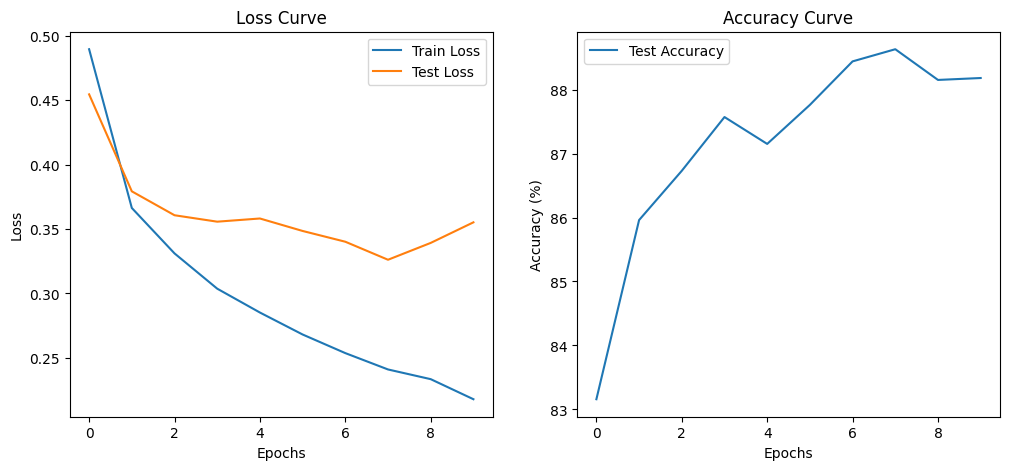

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

batch_size = 64
learning_rate = 0.001
epochs = 10
hidden_layers = [256, 128]
activation_fn = nn.ReLU()
dataset_choice = "FashionMNIST"


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


if dataset_choice == "MNIST":
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
else:
    train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# NOTE: If you have already downloaded the dataset and want to access it from a local folder (e.g., '~/Downloads/fashionmnist'),
# you would change the 'root' argument to the path of your downloaded data and set 'download=False'.
# For example, if your 'fashionmnist' folder is directly inside 'Downloads', you might use root='/home/user/Downloads/fashionmnist'.
# Or if 'fashionmnist' is inside a 'data' folder within 'Downloads', you might use root='/home/user/Downloads/data'.
# Make sure the path specified in 'root' points to the directory containing the dataset files.

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, activation):
        super(MLP, self).__init__()
        layers = []
        in_features = input_size
        for h in hidden_layers:
            layers.append(nn.Linear(in_features, h))
            layers.append(activation)
            in_features = h
        layers.append(nn.Linear(in_features, num_classes))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.network(x)

model = MLP(28*28, hidden_layers, 10, activation_fn)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


train_losses, test_losses, accuracies = [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0 # Resets running loss for the current epoch
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) # Moves images and labels to the selected device

        outputs = model(images)
        loss = criterion(outputs, labels)


        optimizer.zero_grad()
        loss.backward() # Computes gradients
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))



    model.eval()
    correct, total, test_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    test_losses.append(test_loss / len(test_loader))


    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()
plt.show()